In [904]:
# Importing necessary libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from xgboost import XGBRegressor

# Reading the data
df = pd.read_csv('AbsEmployees.csv')
df.head()

,EmployeeNumber,Surname,GivenName,Gender,JobTitle,DepartmentName,StoreLocation,Division,Age,LengthService,AbsentHours,BusinessUnit
0,1,Gutierrez,Molly,F,Baker,Bakery,Burnaby,Stores,32.028816,6.018478,36.577306,Stores
1,2,Hardwick,Stephen,M,Baker,Bakery,Nanaimo,Stores,40.320902,5.532445,30.165072,Stores
2,3,Delgado,Chester,M,Baker,Bakery,Richmond,Stores,48.822047,4.389973,83.807798,Stores
3,4,Simon,Irene,F,Baker,Bakery,Victoria,Stores,44.599357,3.081736,70.020165,Stores
4,5,Delvalle,Edward,M,Baker,Bakery,New Westminster,Stores,35.697876,3.619091,0.000000,Stores


In [905]:
# Check the dimension of the data
df.shape

(8336, 12)

In [906]:
# Check duplicated values through the EmployeeNumber, because it is unique
df['EmployeeNumber'].duplicated().sum()

0

In [907]:
# Check if there is any missing value
df.isnull().sum()

EmployeeNumber    0
Surname           0
GivenName         0
Gender            0
JobTitle          0
DepartmentName    0
StoreLocation     0
Division          0
Age               0
LengthService     0
AbsentHours       0
BusinessUnit      0
dtype: int64

In [908]:
# Check the data type of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8336 entries, 0 to 8335
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EmployeeNumber  8336 non-null   int64  
 1   Surname         8336 non-null   object 
 2   GivenName       8336 non-null   object 
 3   Gender          8336 non-null   object 
 4   JobTitle        8336 non-null   object 
 5   DepartmentName  8336 non-null   object 
 6   StoreLocation   8336 non-null   object 
 7   Division        8336 non-null   object 
 8   Age             8336 non-null   float64
 9   LengthService   8336 non-null   float64
 10  AbsentHours     8336 non-null   float64
 11  BusinessUnit    8336 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 781.6+ KB


### Judging by the data types presented in the requirements document, we can see that most of the data match except categorical data columns. Which will be converted to categorical data type later through encoding, in the model development phase.

In [909]:
# Now we will check what are the unique non-numerical values in each column
for col in df.columns:
    if df[col].dtype == 'object':
        print(col, df[col].unique())

Surname ['Gutierrez' 'Hardwick' 'Delgado' ... 'Bosworth' 'Sheaffer' 'Coniglio']
GivenName ['Molly' 'Stephen' 'Chester' ... 'Hui' 'Camille' 'Bianca']
Gender ['F' 'M']
JobTitle ['Baker' 'Accounting Clerk' 'Accounts Payable Clerk'
 'Accounts Receiveable Clerk' 'Auditor' 'Bakery Manager' 'Benefits Admin'
 'Cashier' 'Compensation Analyst' 'HRIS Analyst' 'Investment Analyst'
 'Labor Relations Analyst' 'Recruiter' 'Dairy Person' 'Systems Analyst'
 'Trainer' 'Meat Cutter' 'CEO' 'VP Stores' 'Legal Counsel'
 'VP Human Resources' 'VP Finance' 'Exec Assistant, VP Stores'
 'Exec Assistant, Human Resources' 'Exec Assistant, Legal Counsel'
 'CHief Information Officer' 'Store Manager' 'Meats Manager'
 'Exec Assistant, Finance' 'Director, Recruitment' 'Director, Training'
 'Director, Labor Relations' 'Director, HR Technology'
 'Director, Employee Records' 'Director, Compensation' 'Corporate Lawyer'
 'Produce Manager' 'Director, Accounts Receivable'
 'Director, Accounts Payable' 'Director, Audit' 'Direc

### Now we will check weather the numerical data are correct logically or not.
### We will make the following assumptions:
#### 1. All the numerical data should be positive
#### 2. The age of the employee should be between 18 and 65
#### 3. The LengthService should be between 0 and 47

In [910]:
df.describe()

,EmployeeNumber,Age,LengthService,AbsentHours
count,8336.000000,8336.000000,8336.000000,8336.000000
mean,4168.500000,42.007086,4.782910,61.283978
std,2406.540255,9.939798,2.462990,49.038365
min,1.000000,3.504743,0.012098,0.000000
25%,2084.750000,35.298748,3.575892,19.127590
50%,4168.500000,42.114924,4.600248,56.005808
75%,6252.250000,48.666943,5.623922,94.284692
max,8336.000000,77.938003,43.735239,272.530123


### We can see that:
#### 1. There are no negative values in the numerical data
#### 2. The age of the employee has out of range values, which will be removed in the next cell
#### 3. The LengthService values are in range.

In [911]:
# Now we will remove out of range age values
df = df[(df['Age'] >= 18) & (df['Age'] < 66)]
df.describe()

,EmployeeNumber,Age,LengthService,AbsentHours
count,8188.000000,8188.000000,8188.000000,8188.000000
mean,4165.298363,42.051355,4.788182,60.840854
std,2402.127549,9.346287,2.476283,47.582281
min,1.000000,18.204720,0.053279,0.000000
25%,2084.750000,35.468279,3.579248,20.180982
50%,4168.500000,42.135686,4.598089,56.192125
75%,6242.250000,48.547181,5.624946,93.590488
max,8336.000000,65.808865,43.735239,252.193535


### Now we will remove outliers from the AbsentHours column using the IQR method with the following method:

In [912]:
#this is function to remove outliers.

def outliers(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return lower_bound, upper_bound

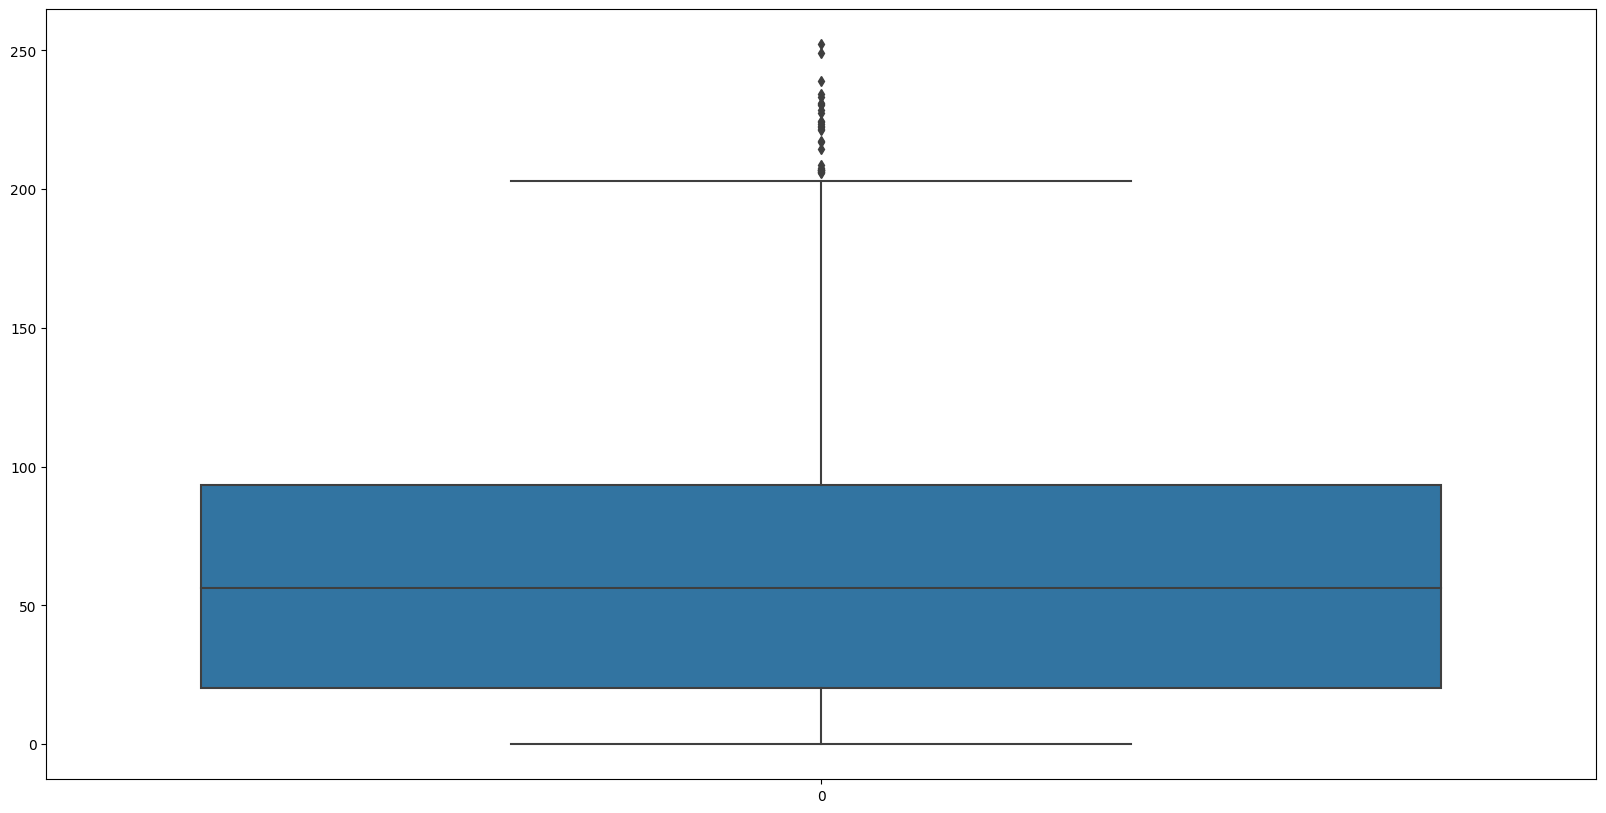

In [913]:
#checking outliers using boxplot

plt.figure(figsize=(20, 10)) 
sns.boxplot(df['AbsentHours'])
plt.show()

203.70474787750004


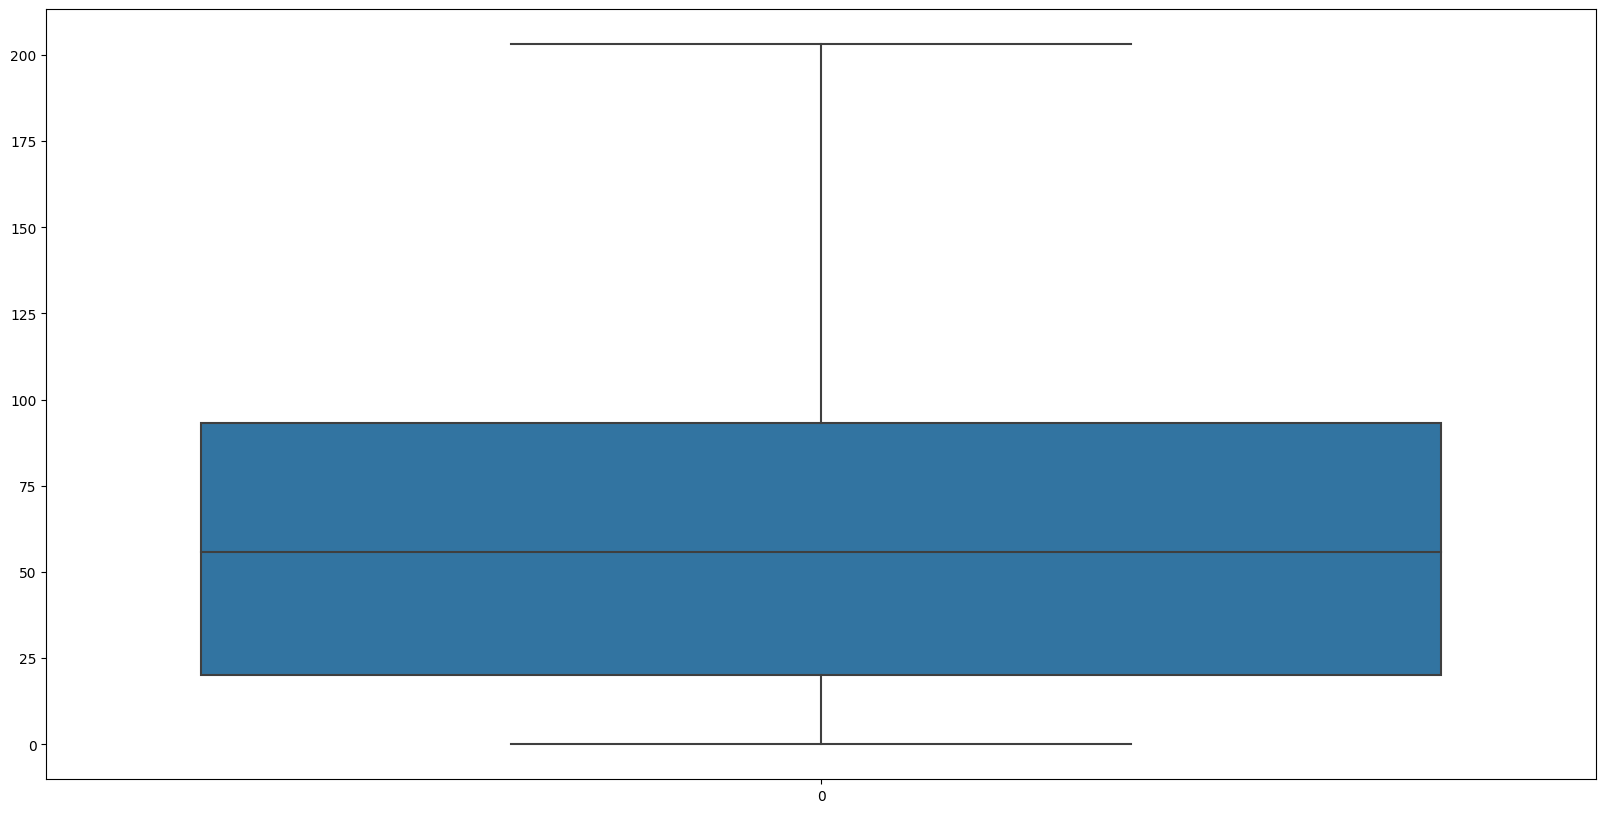

In [914]:
#Removing outliers
lowerB, upperB = outliers(df['AbsentHours']) 
print(upperB)
df=df[(df['AbsentHours']<=upperB)]

plt.figure(figsize=(20, 10))
sns.boxplot(df['AbsentHours'])
plt.show()

### We will create age groups to make visualization easier
### We will use the following groups:
#### 1. 18-25
#### 2. 26-35
#### 3. 36-45
#### 4. 46-55
#### 5. 56-65

In [915]:
df['AgeGroup'] = df['Age'].apply(lambda x: '18-25' if x < 26 else ('26-35' if x < 36 else ('36-45' if x < 46 else ('46-55' if x < 56 else '56-65'))))

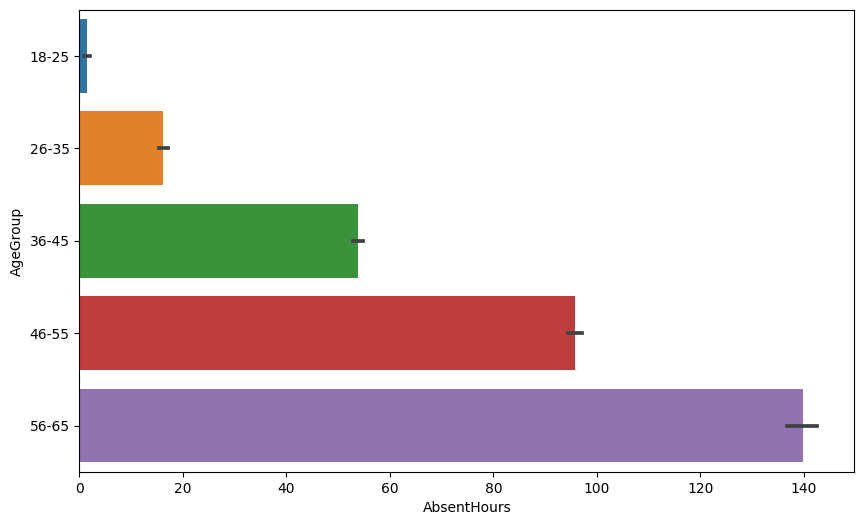

In [916]:
# Now we will create a bar plot to compare AbsentHours with AgeGroup
plt.figure(figsize=(10, 6))
sns.barplot(x=df['AbsentHours'], y=df.sort_values(by='AgeGroup')['AgeGroup'])
plt.show()

### As we can see from the graph above, the percentage of absences gets higher as the age gets higher.

### Similar to the age, we will create length of service group to make visualization easier
### We will use the following groups:
#### 1. 0-9
#### 2. 10-19
#### 3. 20-29
#### 4. 30-39
#### 5. 40-47

In [917]:
df['LengthServiceGroup'] = df['LengthService'].apply(lambda x: '0-9' if x < 10 else ('10-19' if x < 20 else ('20-29' if x < 30 else ('30-39' if x < 40 else '40-47'))))

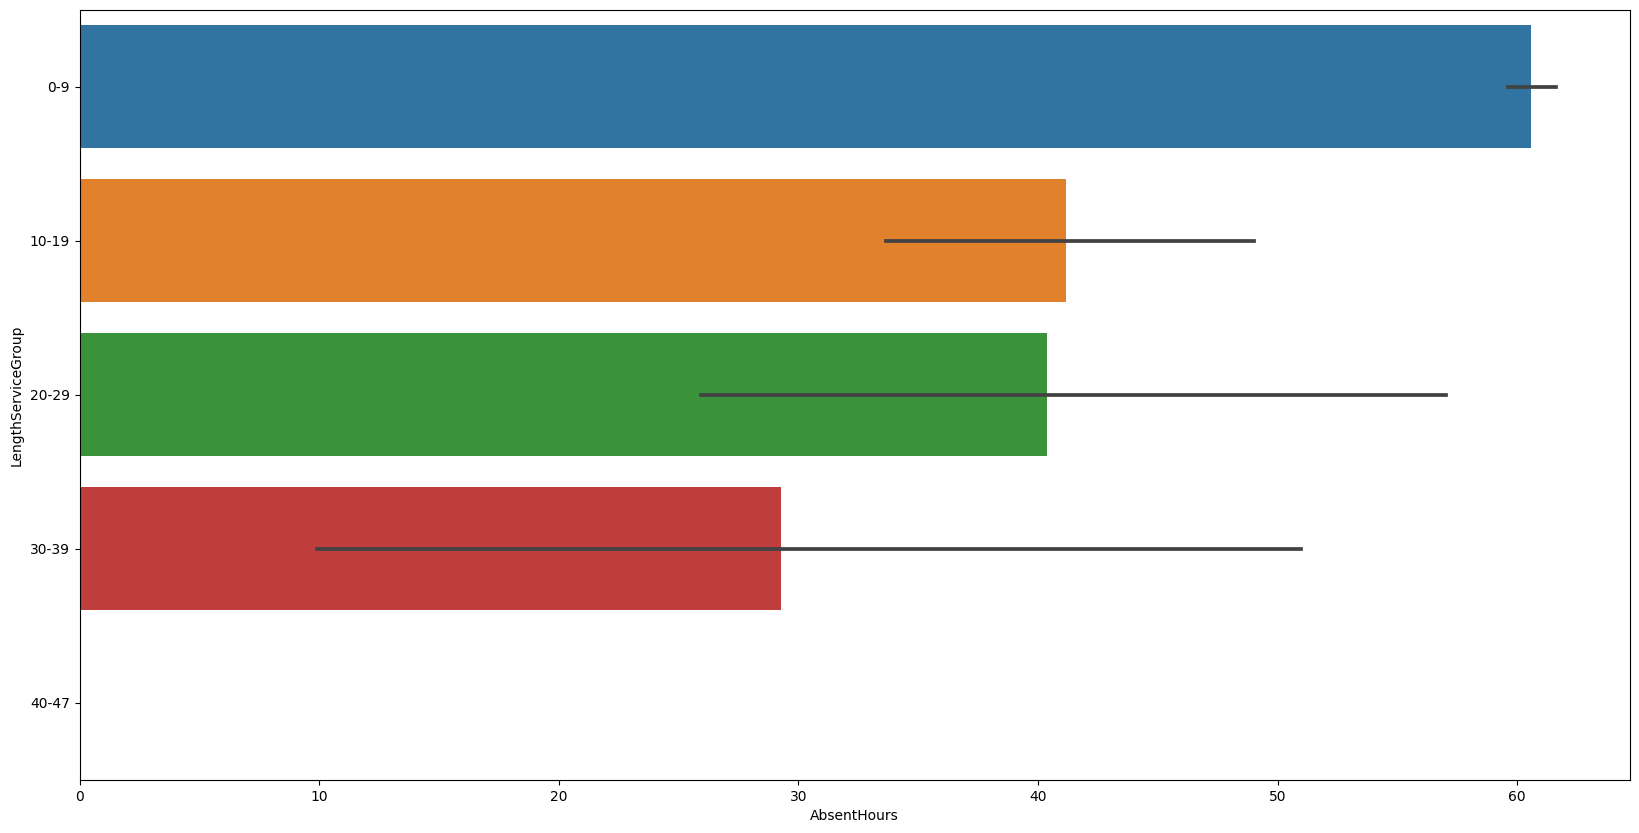

In [918]:
plt.figure(figsize=(20, 10))
sns.barplot(x=df['AbsentHours'], y=df.sort_values(by='LengthServiceGroup')['LengthServiceGroup'])
plt.show()

### As we can see from the graph above, the percentage of absences decreases the longer LengthOfService gets.

### Now we will add a new column called LengthServiceInHours, which will contain the converted value of LengthService column from years to hours
### The formula will be based on the following assumptions:
#### 1. The average working hours per day is 8 hours
#### 2. The average working days per week is 5 days
#### 3. The average working weeks per year is 50 weeks for those who completed 1 year of service, 49 weeks for those who completed 5 years of service, and 48 weeks for those who completed 10 years of service. Which follows the regulation of the government of Canada.

In [919]:
df['LengthServiceInHours'] = df['LengthService'].apply(lambda x: 2000 * x if x < 5 else (1960 * x if x < 10 else 1920 * x))

In [920]:
# Now we will add a new column called PercentageOfAbsence
df['PercentageOfAbsence'] = df['AbsentHours'] / df['LengthServiceInHours'] * 100 

In [921]:
# Now that we calculated the percentage of absence, we will remove the LengthServiceInHours column
df.drop('LengthServiceInHours', axis=1, inplace=True)

In [922]:
# Now we will round the numerical data to 3 decimal places, except for Age column which will be floored
df['Age'] = df['Age'].apply(lambda x: int(x))
df['LengthService'] = df['LengthService'].apply(lambda x: round(x, 3))
df['PercentageOfAbsence'] = df['PercentageOfAbsence'].apply(lambda x: round(x, 3))
df['AbsentHours'] = df['AbsentHours'].apply(lambda x: round(x, 3))

In [923]:
# Because name has no effect on absences, we will remove the Surname, and the GivenName columns
df.drop(['Surname', 'GivenName'], axis=1, inplace=True)

In [924]:
# And we will drop the AbsentHours column, because we already have the PercentageOfAbsence column
df.drop('AbsentHours', axis=1, inplace=True)

In [925]:
# Now we will check the correlation between PercentageOfAbsence and the other numerical columns.
df.corr()['PercentageOfAbsence'].sort_values(ascending=False)

C:\Users\inter\AppData\Local\Temp\ipykernel_19940\2170383963.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()['PercentageOfAbsence'].sort_values(ascending=False)


PercentageOfAbsence    1.000000
Age                    0.337505
EmployeeNumber         0.005305
LengthService         -0.210827
Name: PercentageOfAbsence, dtype: float64

### From the above table we can see that there could be a correlation between absence and both age and length of service. however, further analysis is required as we cannot draw any conclusion about absence and the other categorical data such as business unit or divisions.

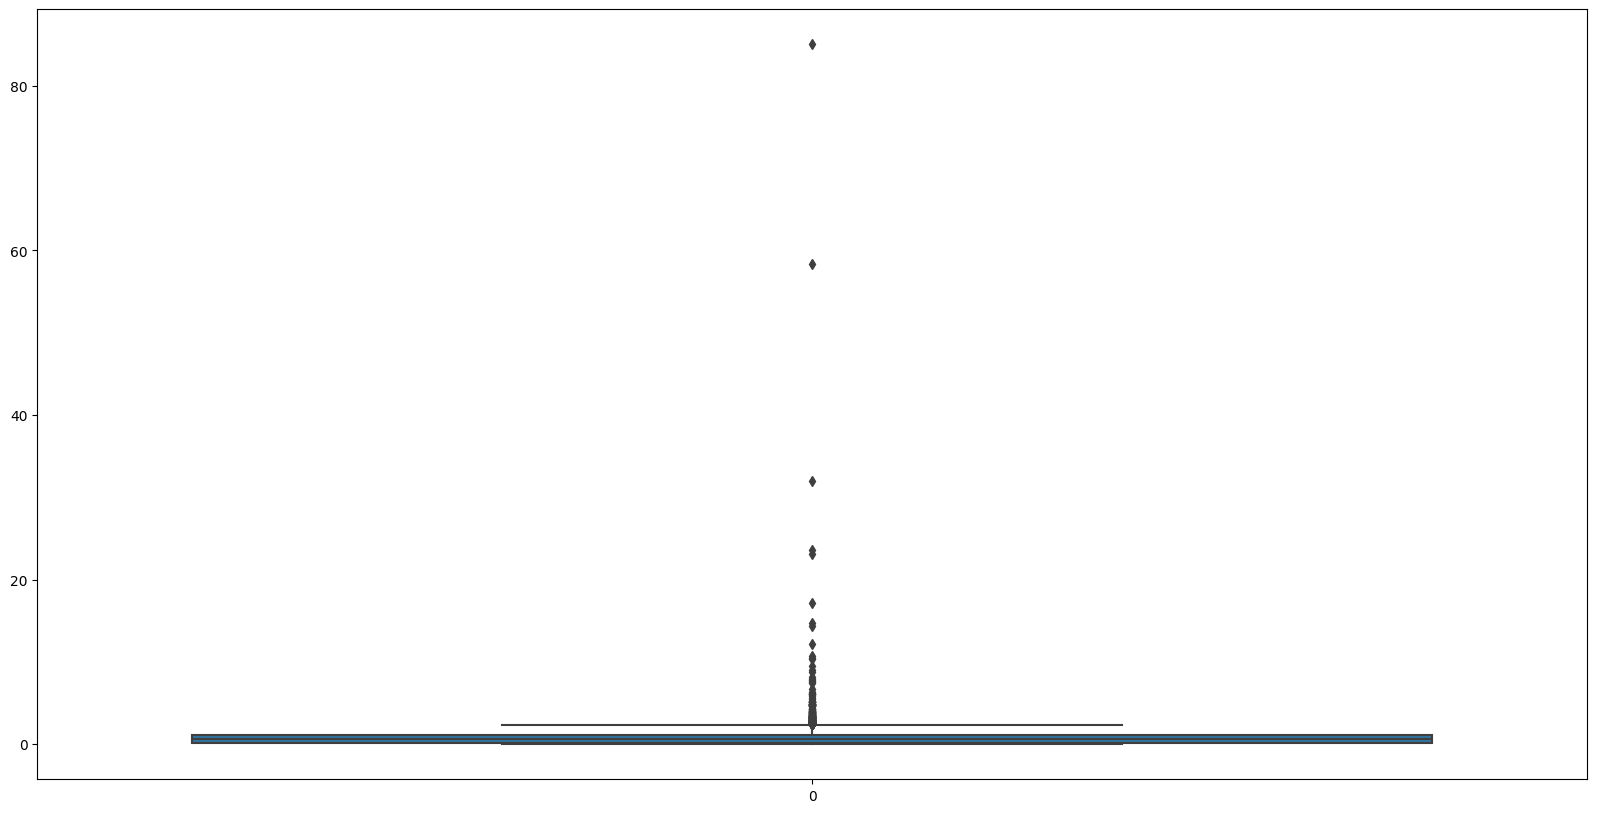

In [926]:
#checking outliers using boxplot

plt.figure(figsize=(20, 10)) 
sns.boxplot(df['PercentageOfAbsence'])
plt.show()

### Now we will remove outliers from the PercentageOfAbsence column using the IQR method created above:

2.404


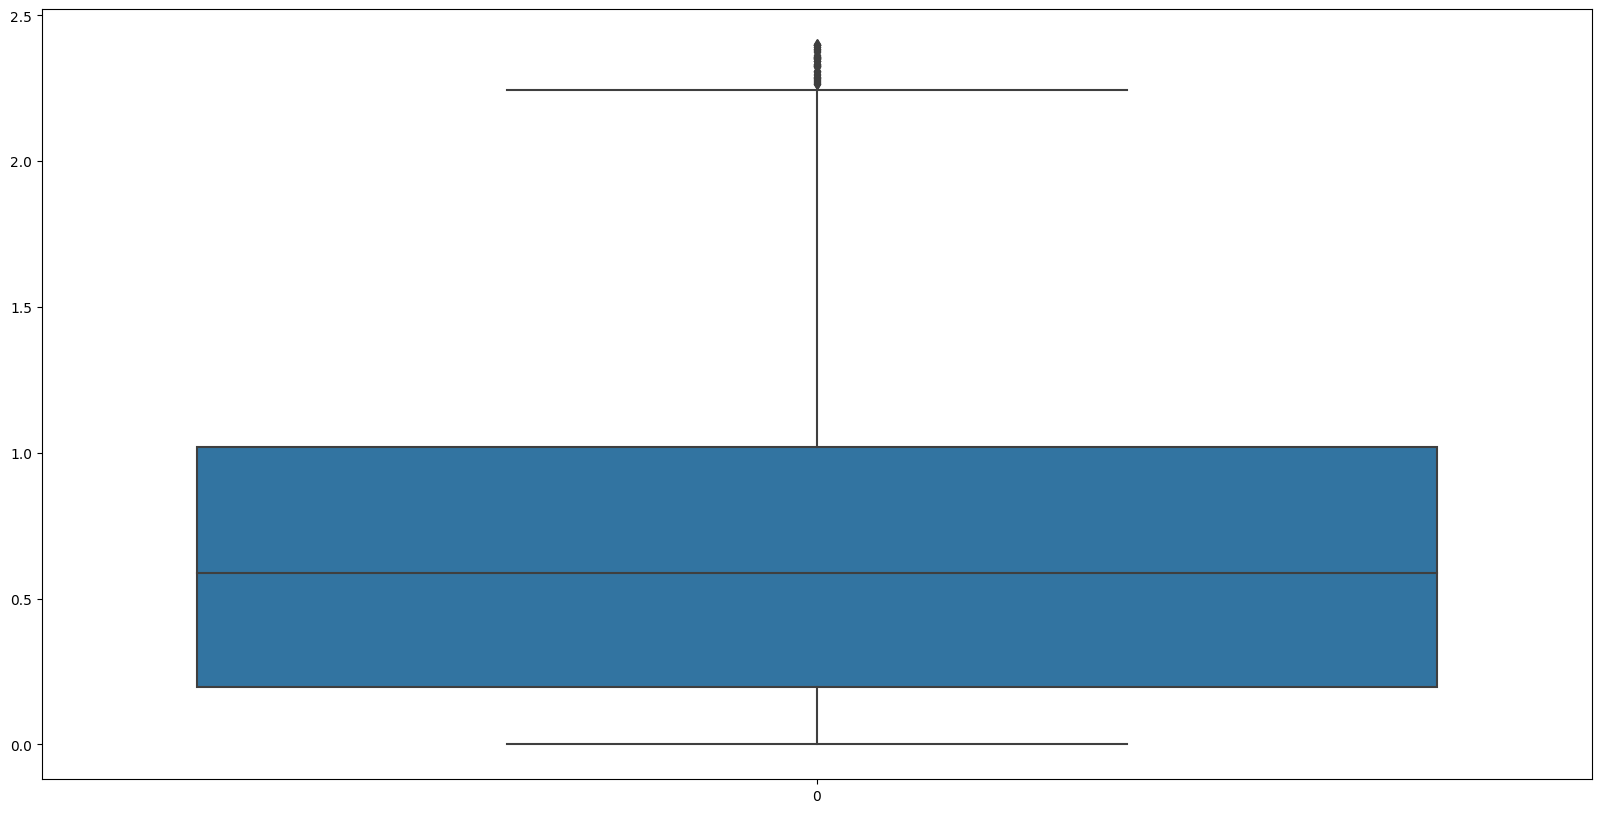

In [927]:
#Removing outliers
lowerB, upperB = outliers(df['PercentageOfAbsence']) 
print(upperB)
df=df[(df['PercentageOfAbsence']<=upperB)]

plt.figure(figsize=(20, 10))
sns.boxplot(df['PercentageOfAbsence'])
plt.show()

### As we can see from the two boxplots above, there are some unrealistic values that arose from using percentage of absent hours rather than the actual number of hours. However, working with percentages is still better as it provides a fairer overview of the data. Therefore, we will eliminate the outliers and continue using percentages which will result in clearer data and hopefully better analysis overall.

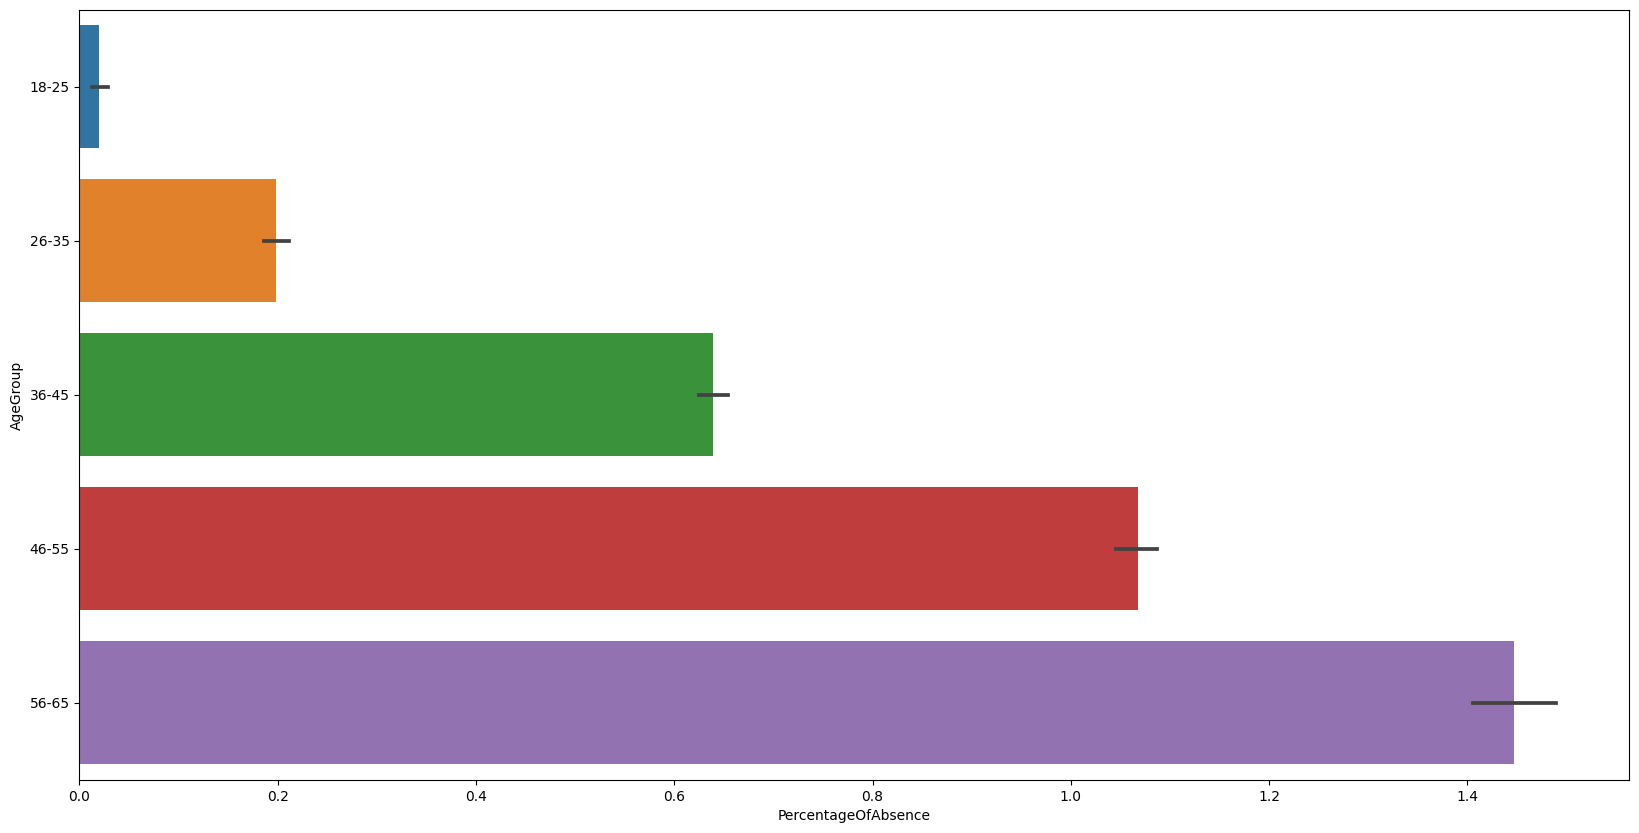

In [928]:
# Now we will draw a bar plot for each age group
plt.figure(figsize=(20, 10))
sns.barplot(x=df['PercentageOfAbsence'], y=df.sort_values(by='AgeGroup')['AgeGroup'])
plt.show()

### As we can see from the graph above, the percentage of absences gets higher as the age gets higher. Same as the plot created previously using AbsentHours

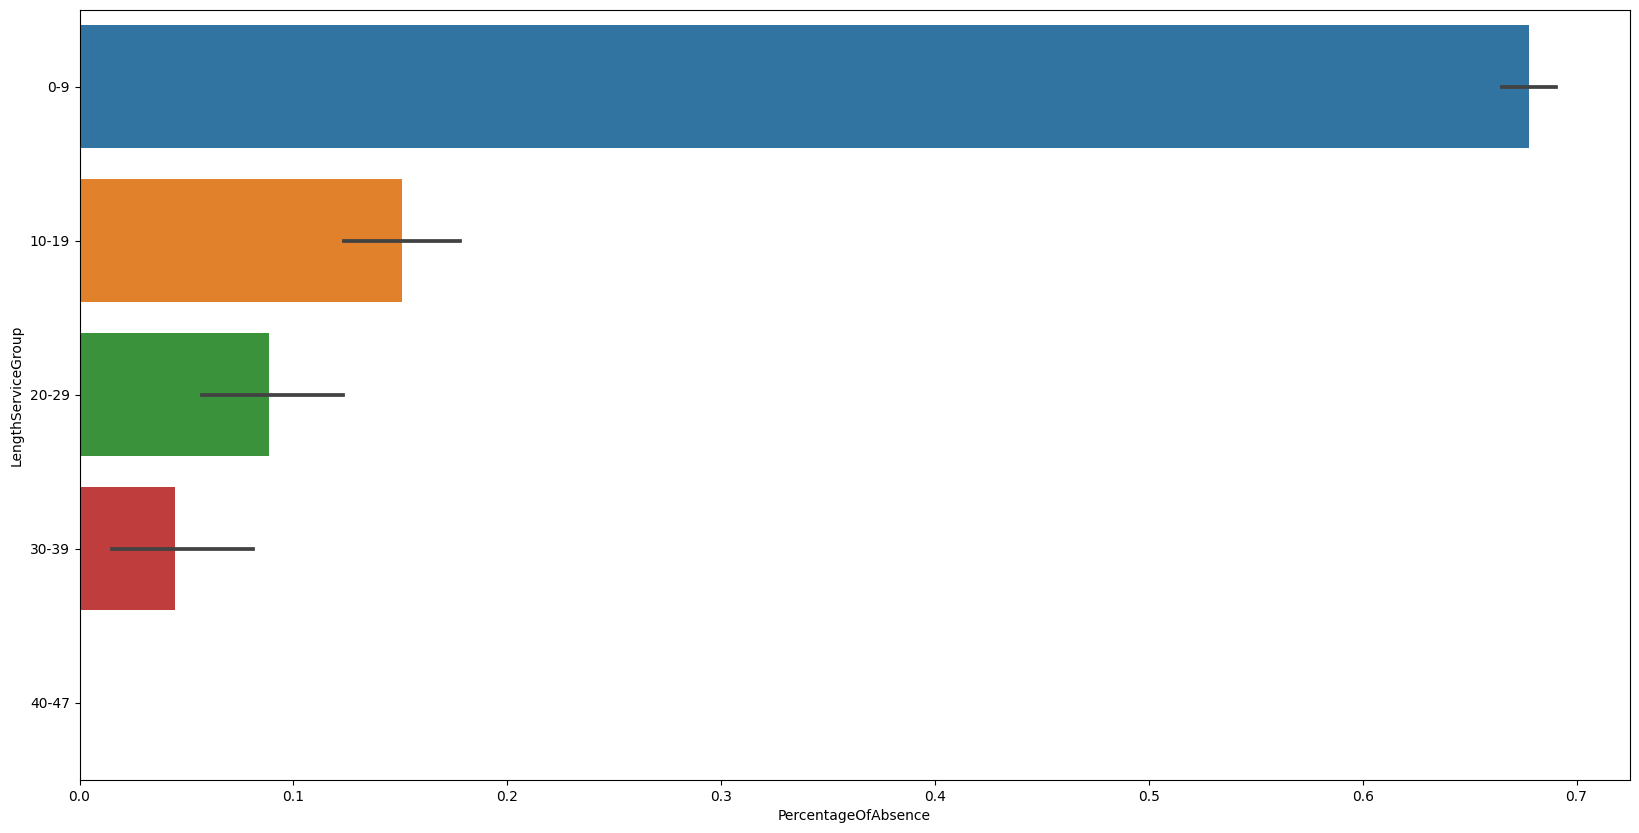

In [929]:
plt.figure(figsize=(20, 10))
sns.barplot(x=df['PercentageOfAbsence'], y=df.sort_values(by='LengthServiceGroup')['LengthServiceGroup'])
plt.show()

### From the graph above, we can see that the percentage of absences decreases as the length of service increases. Also same as the plot created previously using AbsentHours
### So from this point onward we will use PercentageOfAbsences

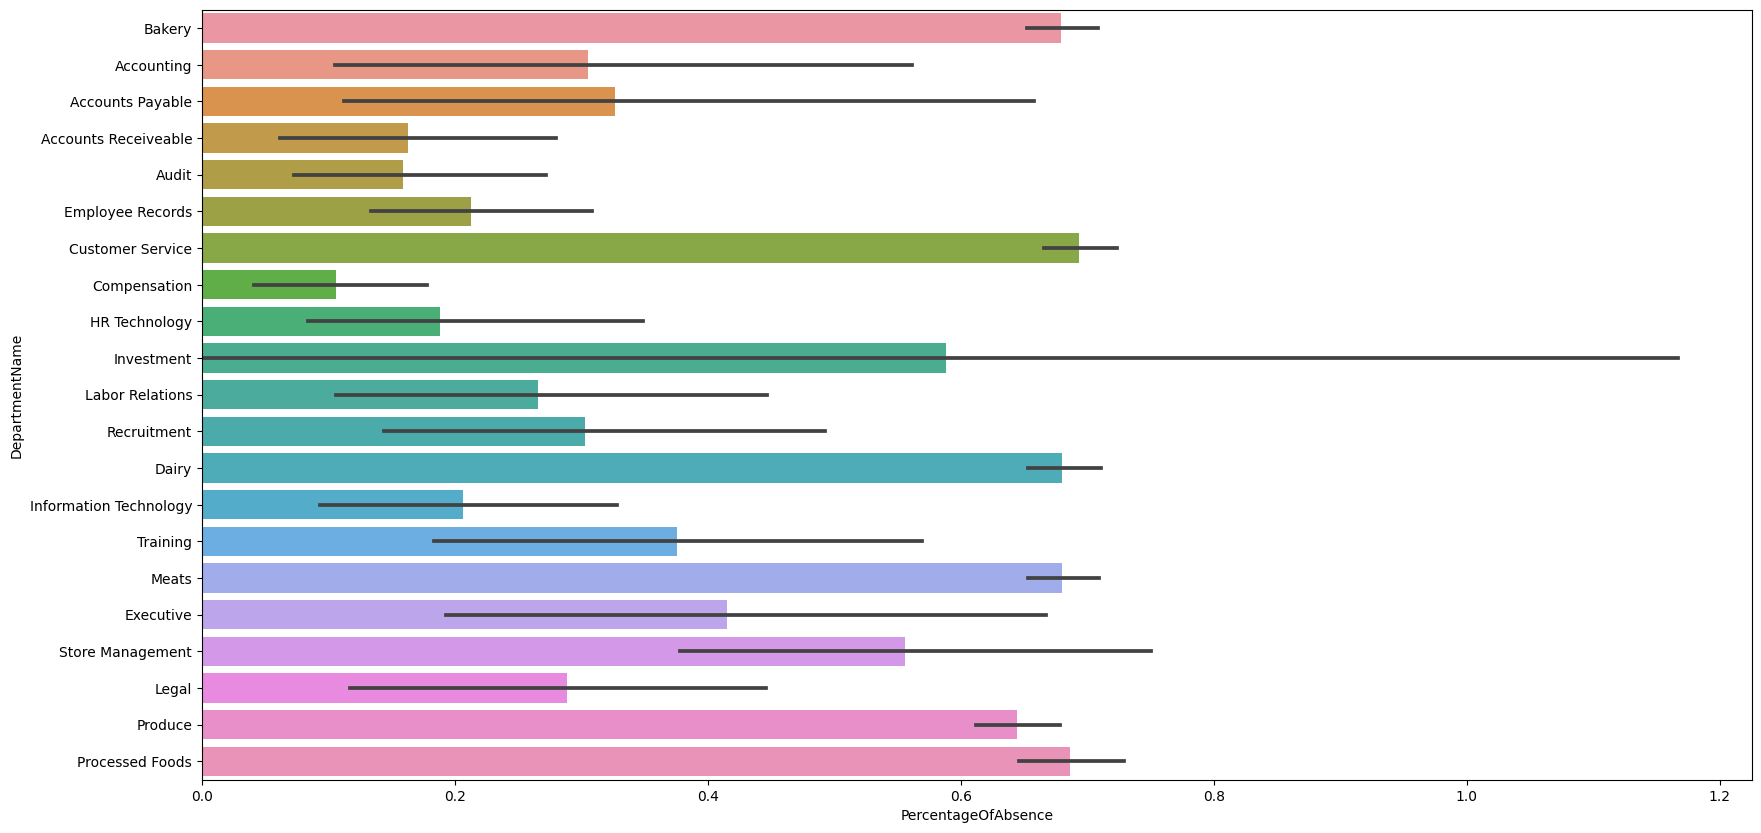

In [930]:
# Next we will draw a bar plot for the DepartmentName column to see the relation between the percentage of absence and each department
plt.figure(figsize=(20, 10))
sns.barplot(x=df['PercentageOfAbsence'], y=df['DepartmentName'])
plt.show()

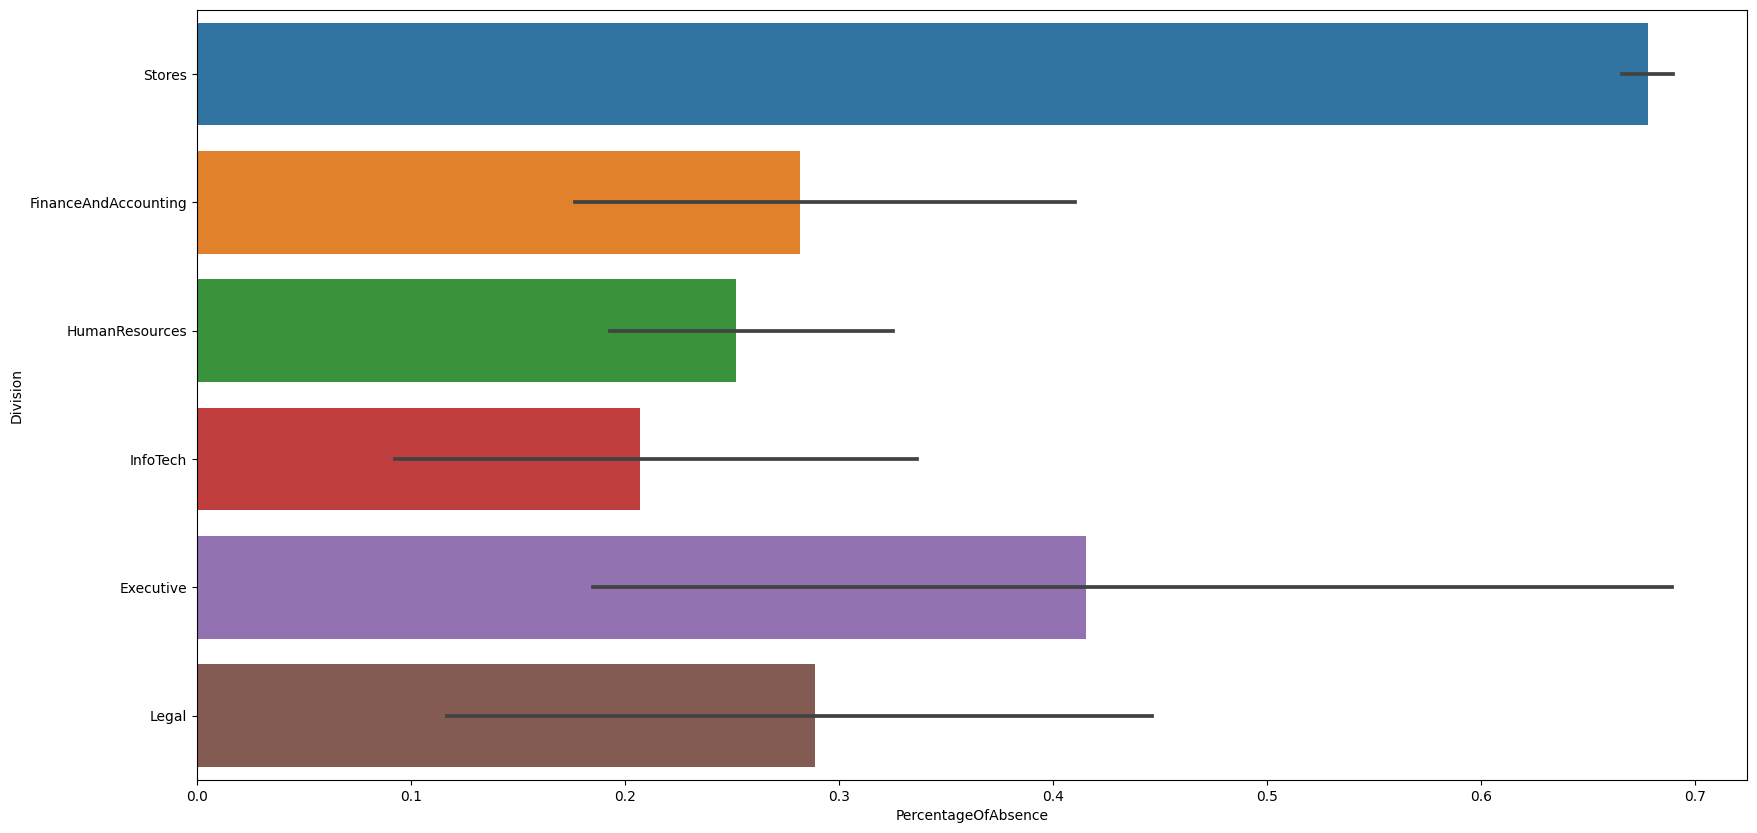

In [931]:
# Now we will draw a bar plot for the Division column to see the relation between the percentage of absence and each division
plt.figure(figsize=(20, 10))
sns.barplot(x=df['PercentageOfAbsence'], y=df['Division'])
plt.show()

In [932]:
# We will group the data by Division and DepartmentName and see the mean value of PercentageOfAbsence for each group to further investigate Division and DepartmentName columns
df.groupby(['Division', 'DepartmentName'])['PercentageOfAbsence', 'LengthService'].mean().sort_values(by='PercentageOfAbsence',ascending=False)
# As shown in the following table, there is a noticeable change in absence in Stores Division and those below them. Furthermore, it is important to note that the average number of years worked in the company for those in stores division ,being about 4.7 years, is much lower than other divisions which all have an average 
# higher than 10 years. 
# possible reasons could be :
# 1. work environment in stores could be toxic causing dissatisfaction among employees which result in high absenteeism and relatively high turnover as shown by the table above.
# 2. Employee loyalty in these departments could be low, and the few that are loyal get promoted or moved to other departments leaving poor performing employees condensed in stores division, explaining the disparity in the data. 

C:\Users\inter\AppData\Local\Temp\ipykernel_19940\3280893863.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['Division', 'DepartmentName'])['PercentageOfAbsence', 'LengthService'].mean().sort_values(by='PercentageOfAbsence',ascending=False)


PercentageOfAbsence  \
Division             DepartmentName                                
Stores               Customer Service                   0.693839   
                     Processed Foods                    0.686757   
                     Meats                              0.680396   
                     Dairy                              0.680116   
                     Bakery                             0.679453   
                     Produce                            0.644201   
FinanceAndAccounting Investment                         0.588125   
Stores               Store Management                   0.555919   
Executive            Executive                          0.415545   
HumanResources       Training                           0.375333   
FinanceAndAccounting Accounts Payable                   0.326467   
                     Accounting                         0.305563   
HumanResources       Recruitment                        0.302846   
Legal                Legal                              0.288667   
HumanResources       Labor Relations                    0.265417   
                     Employee Records                   0.212583   
InfoTech             Information Technology             0.206800   
HumanResources       HR Technology                      0.188643   
FinanceAndAccounting Accounts Receiveable               0.163200   
                     Audit                              0.159214   
HumanResources       Compensation                       0.106333   

                                             LengthService  
Division             DepartmentName                         
Stores               Customer Service             4.648693  
                     Processed Foods              4.667981  
                     Meats                        4.635440  
                     Dairy                        4.682915  
                     Bakery                       4.682818  
                     Produce                      4.676407  
FinanceAndAccounting Investment                   8.638875  
Stores               Store Management             4.818486  
Executive            Executive                   11.213000  
HumanResources       Training                    16.570867  
FinanceAndAccounting Accounts Payable            10.572733  
                     Accounting                  10.442312  
HumanResources       Recruitment                 19.762615  
Legal                Legal                       11.209333  
HumanResources       Labor Relations             20.814000  
                     Employee Records            17.599917  
InfoTech             Information Technology      11.590600  
HumanResources       HR Technology               19.156286  
FinanceAndAccounting Accounts Receiveable        12.804000  
                     Audit                       18.518357  
HumanResources       Compensation                20.500444

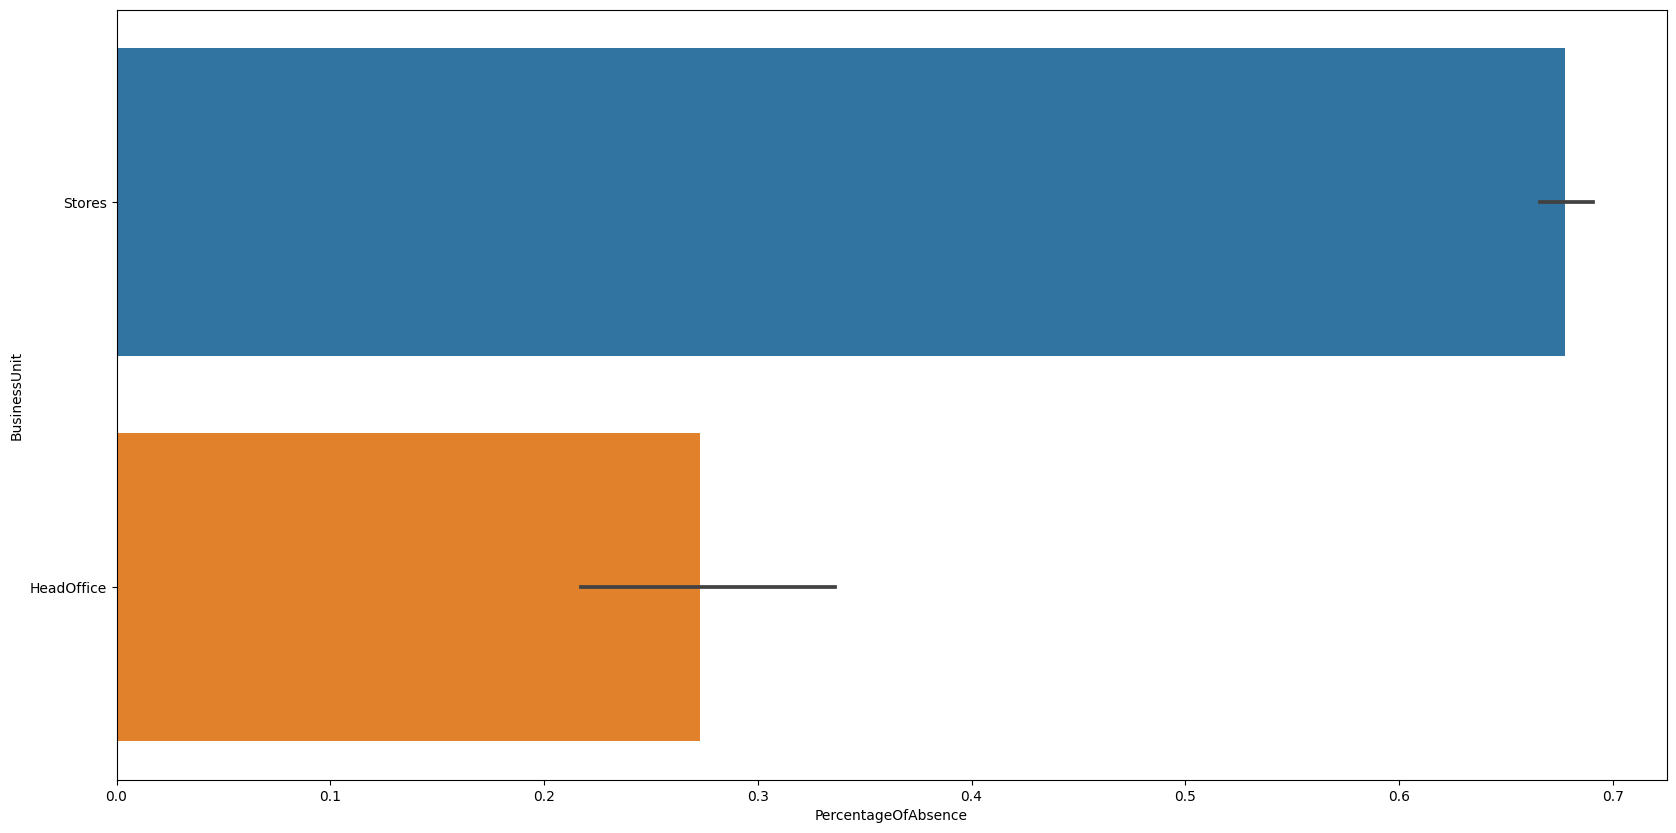

In [933]:
# Now we will draw a bar plot for the BusinessUnit column to see the relation between the percentage of absence and each business unit
plt.figure(figsize=(20, 10))
sns.barplot(x=df['PercentageOfAbsence'], y=df['BusinessUnit'])
plt.show()

### The classification of business units is redundant with divisions. 'Stores' business unit represents all divisions working in the stores and shops which is one division in case being 'stores' division, while head office business unit represents all division working in offices, which are all other divisions besides 'stores' division in this case. Hence the information provided by business units and divisions is redundant.

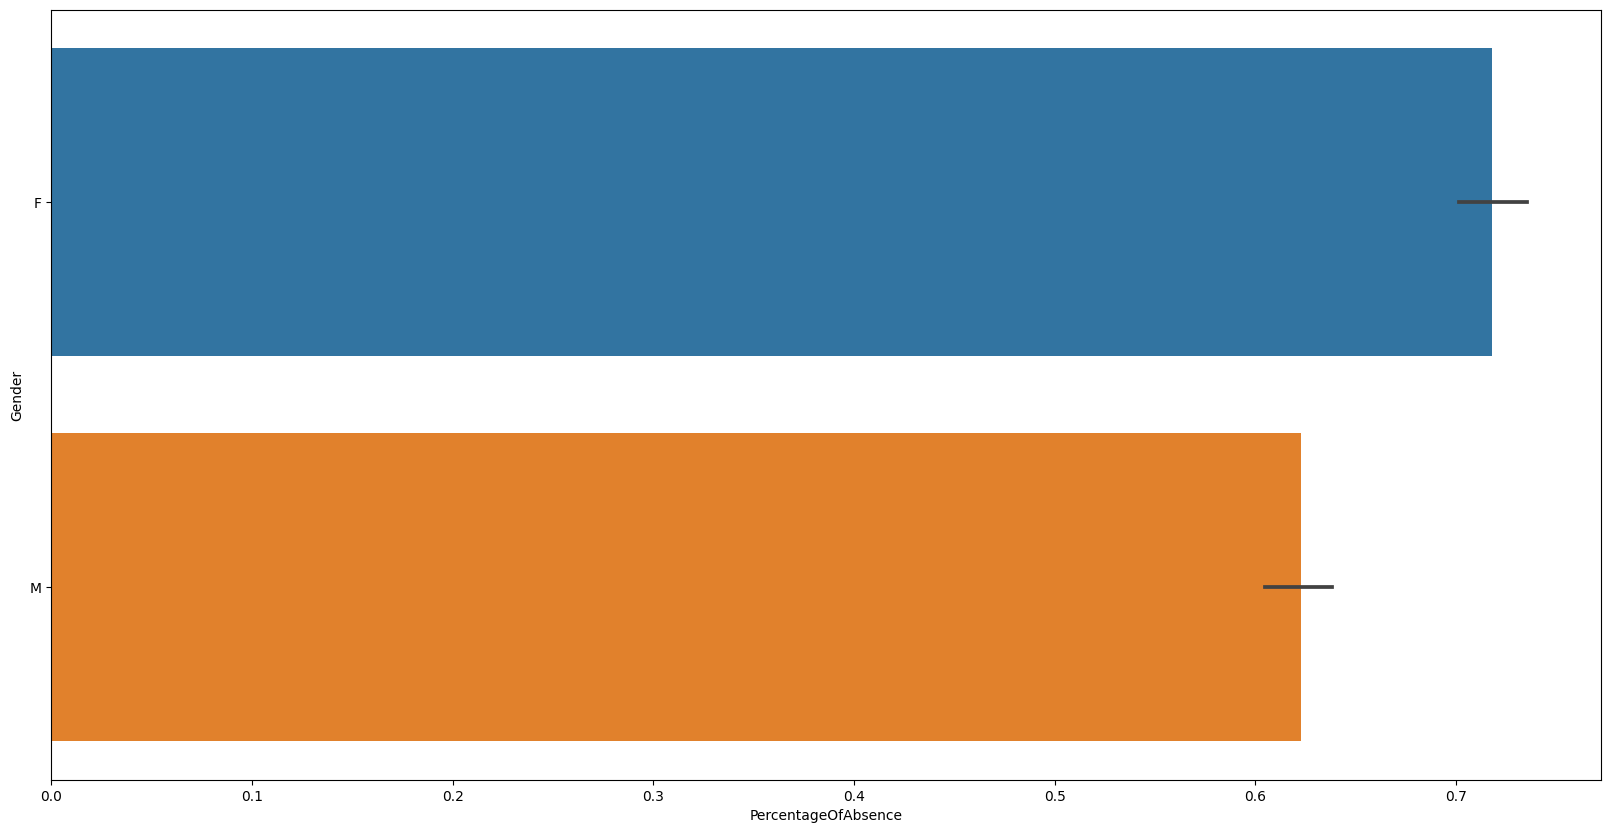

In [934]:
# Now we will draw a bar plot for the Gender column to see the relation between the percentage of absence and each gender
plt.figure(figsize=(20, 10))
sns.barplot(x=df['PercentageOfAbsence'], y=df['Gender'])
plt.show()

In [935]:
# We will group the previous table by gender to further investigate the gender column
df.groupby(['Division', 'DepartmentName', 'Gender'])['PercentageOfAbsence', 'LengthService'].mean().sort_values(by='PercentageOfAbsence',ascending=False)

C:\Users\inter\AppData\Local\Temp\ipykernel_19940\1904615395.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['Division', 'DepartmentName', 'Gender'])['PercentageOfAbsence', 'LengthService'].mean().sort_values(by='PercentageOfAbsence',ascending=False)


PercentageOfAbsence  \
Division             DepartmentName         Gender                        
FinanceAndAccounting Investment             F                  0.772000   
Stores               Customer Service       F                  0.752312   
                     Processed Foods        F                  0.751024   
                     Store Management       F                  0.745588   
                     Dairy                  F                  0.724577   
                     Bakery                 F                  0.717910   
                     Meats                  F                  0.715139   
                     Produce                F                  0.703969   
                     Meats                  M                  0.643583   
                     Bakery                 M                  0.642752   
                     Dairy                  M                  0.639891   
                     Customer Service       M                  0.637680   
                     Processed Foods        M                  0.627258   
                     Produce                M                  0.590243   
FinanceAndAccounting Investment             M                  0.526833   
Executive            Executive              F                  0.474200   
FinanceAndAccounting Accounting             F                  0.455000   
HumanResources       Labor Relations        F                  0.413600   
FinanceAndAccounting Accounts Payable       F                  0.412778   
Stores               Store Management       M                  0.394700   
HumanResources       Training               F                  0.377000   
                                            M                  0.373875   
Executive            Executive              M                  0.366667   
HumanResources       Recruitment            F                  0.344778   
InfoTech             Information Technology F                  0.303000   
Legal                Legal                  F                  0.303000   
                                            M                  0.281500   
HumanResources       HR Technology          M                  0.248600   
                     Employee Records       F                  0.237500   
FinanceAndAccounting Accounts Receiveable   F                  0.212125   
HumanResources       Recruitment            M                  0.208500   
FinanceAndAccounting Accounts Payable       M                  0.197000   
InfoTech             Information Technology M                  0.196111   
FinanceAndAccounting Audit                  M                  0.191571   
HumanResources       Employee Records       M                  0.162750   
                     Labor Relations        M                  0.159571   
                     HR Technology          F                  0.155333   
FinanceAndAccounting Audit                  F                  0.126857   
HumanResources       Compensation           M                  0.124167   
FinanceAndAccounting Accounting             M                  0.113429   
                     Accounts Receiveable   M                  0.107286   
HumanResources       Compensation           F                  0.070667   

                                                    LengthService  
Division             DepartmentName         Gender                 
FinanceAndAccounting Investment             F            4.802500  
Stores               Customer Service       F            4.680738  
                     Processed Foods        F            4.593273  
                     Store Management       F            4.808824  
                     Dairy                  F            4.709596  
                     Bakery                 F            4.676076  
                     Meats                  F            4.628134  
                     Produce                F            4.676012  
                     Meats                  M            4.643182  
   

### The above two figuers illustrate an interesting observation which is women being absent more than men especally in the poor performing areas such as investments and the 'store' division. Female employees in store division illustrates the weakest performance among the entire company which could be due to any number of factors. The more interesting observation is that Women in investment department worsened the average performance of the department by a huge margin causing a bizarre result where their data was higher than the rest of the Finance and Accounting Division by a lot, making the departmnet seem worse than it actually is.

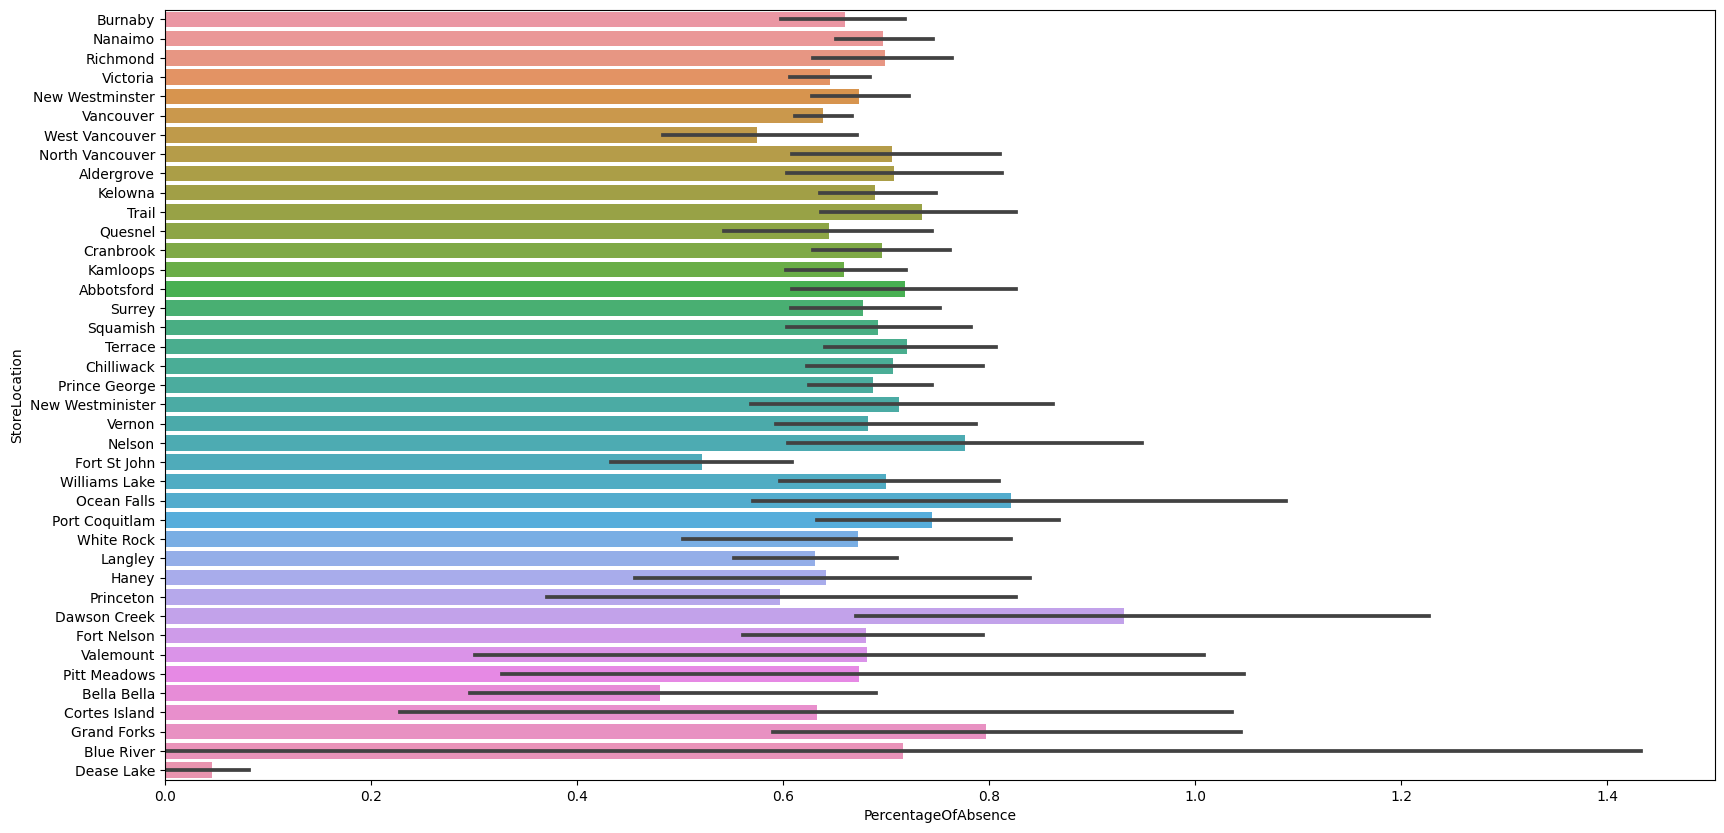

In [936]:
# Now we will draw a bar plot for the StoreLocation column to see the relation between the percentage of absence and each store location
plt.figure(figsize=(20, 10))
sns.barplot(x=df['PercentageOfAbsence'], y=df['StoreLocation'])
plt.show()

### The Data available related to the different regions show no obvious trend and hence will not be examined further. 

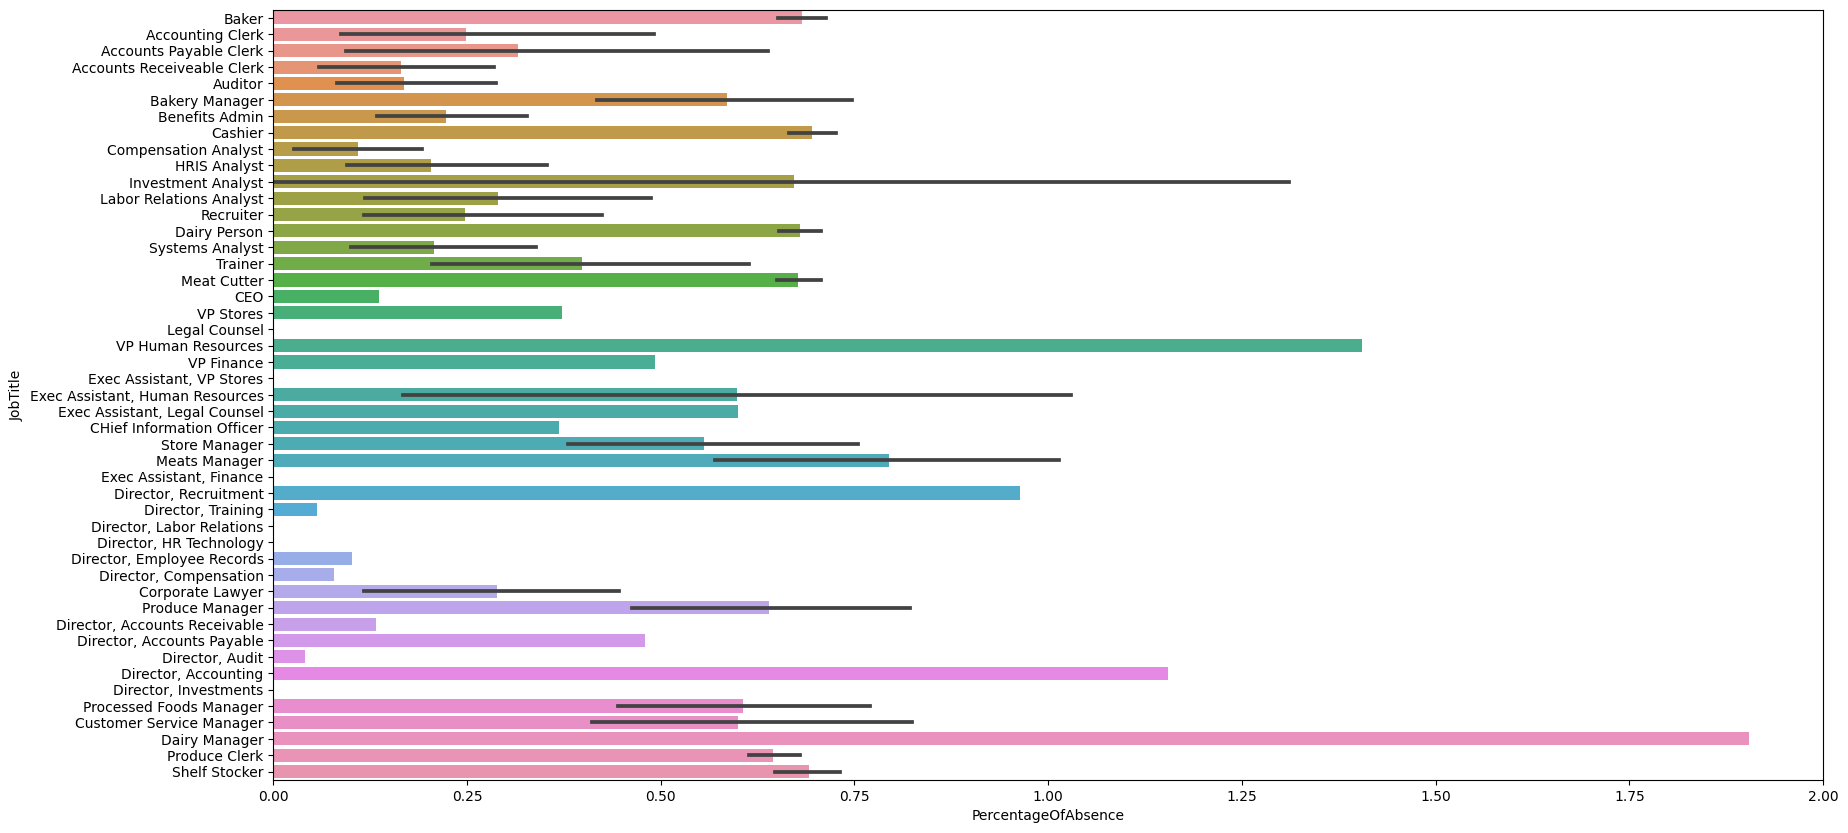

In [937]:
# Finally we will draw a bar plot for the JobTitle column to see the relation between the percentage of absence and each job title
plt.figure(figsize=(20, 10))
sns.barplot(x=df['PercentageOfAbsence'], y=df['JobTitle'])
plt.show()

### The Data related to job titles provide no additional information that what was provided by previous analysis.

In [938]:
# Since we established which factors are related to absenteeism the most, hence we will create a new dataframe containing only the relevant data and all of the following work will be done on this new dataframe.  
df_new = df[['Division', 'Age', 'LengthService', 'Gender', 'PercentageOfAbsence']]

### Next we will build a model to predict the percentage of absence of an employee based on the other features.
### We will use one of the following models:
#### 1. Linear Regression
#### 2. Random Forest
### We will use the following metrics to judge the performance of the models:
#### 1. Mean Absolute Error
#### 2. Mean Squared Error
#### 3. R2 Score
### We will chose the best model based on the aforementioned metrics and use it to create suitable predictions.

In [964]:
# First we will make a copy of the dataframe to keep the original data
df_copy = df_new.copy()

# Now we will encode the non-numerical columns
for col in df_copy.columns:
    if df_copy[col].dtype == 'object':
        df_copy[col] = LabelEncoder().fit_transform(df_copy[col])
        

# Now we will split the data into training and testing sets
X = df_copy.drop('PercentageOfAbsence', axis=1)
y = df_copy['PercentageOfAbsence']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=80)

In [975]:
# Create a forecast model to predict the percentage of absence for each employee
# We will use the Random Forest Regressor model


# Now we will create the first model
model = RandomForestRegressor(n_estimators=80)
model.fit(X_train, y_train)

# Now we will test the model
y_pred = model.predict(X_test)

# Now we will calculate the mean absolute error, mean squared error
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('R2 Score:', r2_score(y_test, y_pred))

Mean Absolute Error: 0.22835984599725043
Mean Squared Error: 0.0949108231996272
R2 Score: 0.6858459902849094


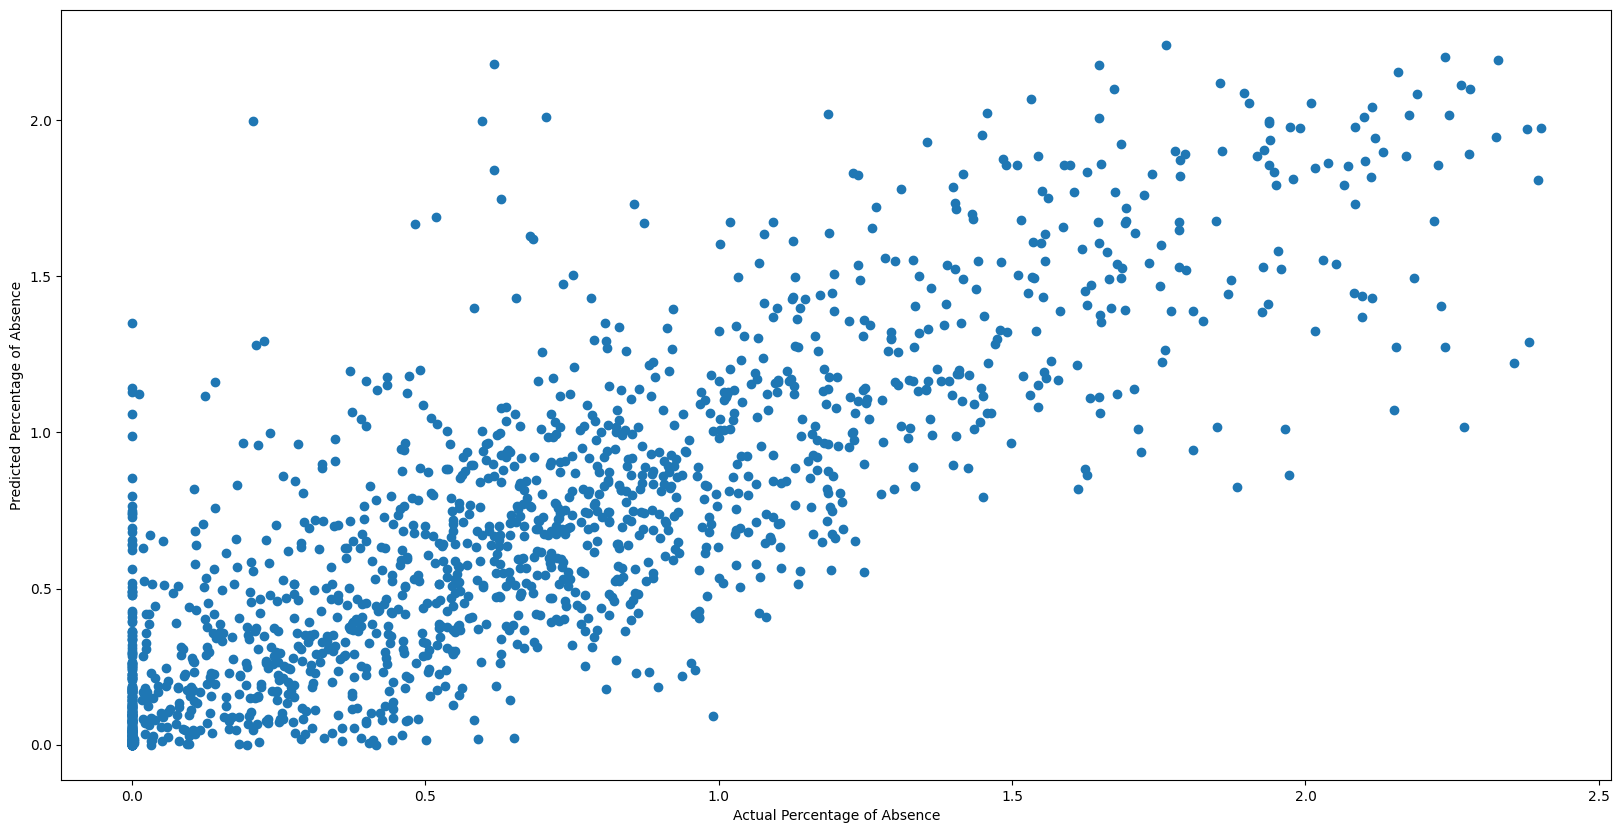

In [954]:
# Now we will visualize the results using a scatter plot to check how the data fits
plt.figure(figsize=(20, 10))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Percentage of Absence')
plt.ylabel('Predicted Percentage of Absence')
plt.show()

In [955]:
# Now we will evaluate the model by comparing the actual percentage of absence with the predicted percentage of absence
df_eval = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_eval.sample(10)

,Actual,Predicted
6880,0.715,1.057383
6644,0.000,0.078900
1700,1.883,0.824550
4455,0.496,1.086962
4879,0.078,0.180617
8091,0.377,0.367483
3522,0.000,0.121883
6198,0.000,0.168133
763,0.180,0.830883
6741,0.694,0.715900


#### We can see from the plot above that is fit to an extent to a regression line. Moreover, the predicted data is close to the actual data. Also, the R squared score is above 0.4 which consider as a good score, and the means' errors are fairly low. However, there is a room for improvement.

In [976]:
# Now we will use the XGBoost Regressor model to create a forecast model using linear regression
# We used the XGRegressor model because it is a very powerful model and fit the data better than the other linear regression models

# Now we will create the model
model = XGBRegressor(n_estimators=80)
model.fit(X_train, y_train)

# Now we will test the model
y_pred = model.predict(X_test)

# Now we will calculate the mean absolute error, mean squared error, and the r2 score
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('R2 Score:', r2_score(y_test, y_pred))

Mean Absolute Error: 0.20884145781323096
Mean Squared Error: 0.08043856316970951
R2 Score: 0.7337490466989849


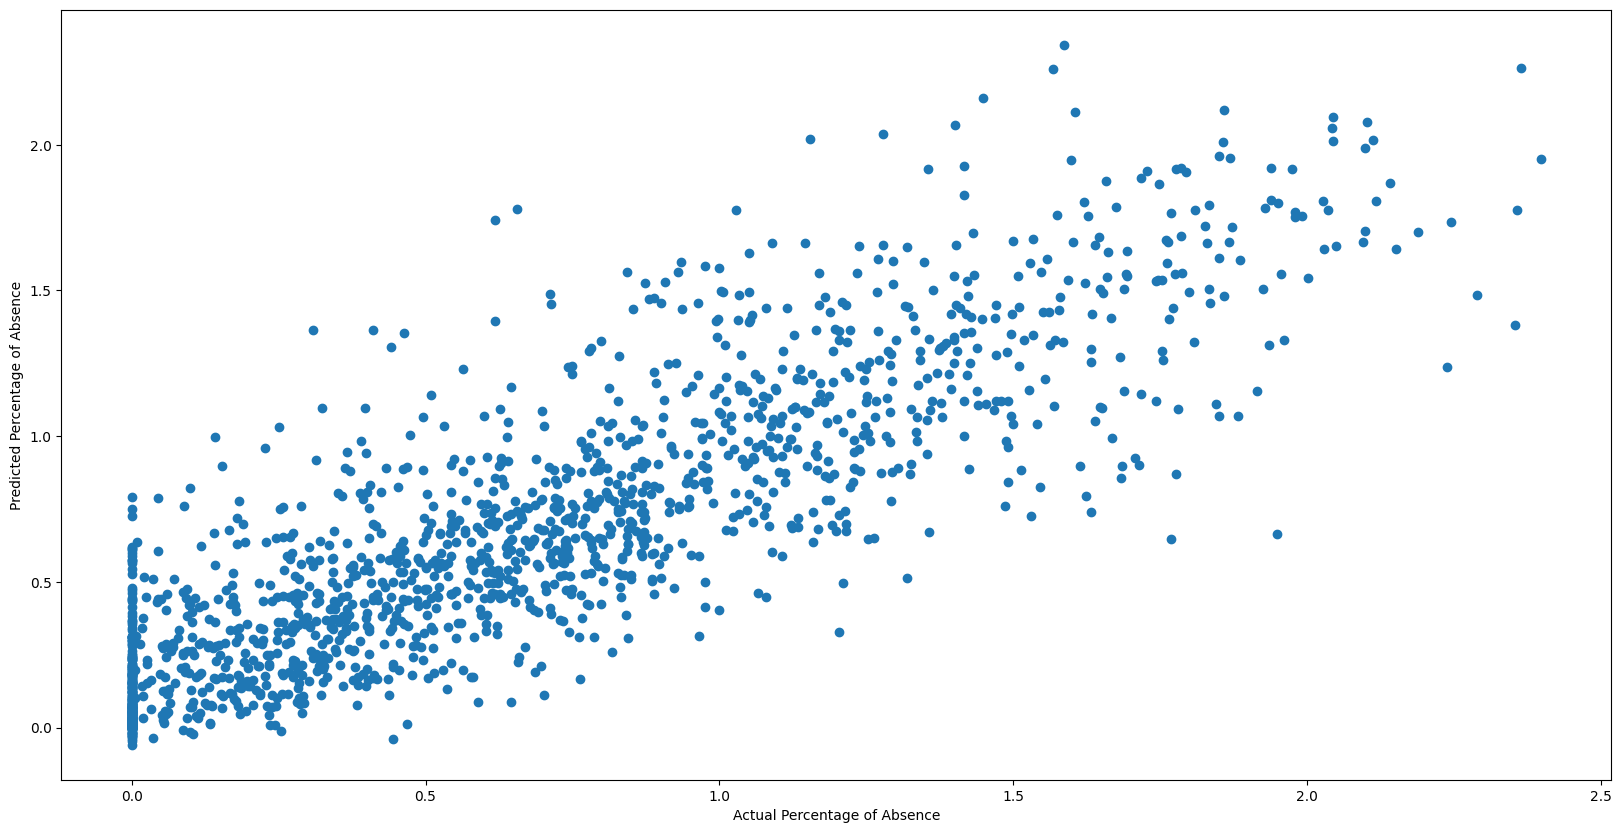

In [977]:
# Now we will visualize the results using a scatter plot to check how the data fits
plt.figure(figsize=(20, 10))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Percentage of Absence')
plt.ylabel('Predicted Percentage of Absence')
plt.show()

In [945]:
# Now we will evaluate the model by comparing the actual percentage of absence with the predicted percentage of absence
df_eval = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_eval.sample(10)

,Actual,Predicted
3524,1.724,1.600842
3483,1.445,1.324188
2711,0.561,0.511372
5377,1.438,1.288303
6853,0.970,1.152758
1039,0.679,0.263144
3841,0.759,0.556781
3024,0.523,0.771509
7893,1.851,1.832783
2063,0.086,0.290566


#### We can see from the data above that the XGBRegressor model fits a regression line and has a higher R squared score than the first model. Also the predicted data is closer to the actual data.

<br><br>

### We can clearly see that Time Series forecasting does not fit the data at all as it is not a time series data. The data is not sequential and the time between each observation is not constant. Hence we will not use it. 
### Also, we can notice that linear regression using XGRegressor is slightly better than Random Forest Regressor. Hence we will use it to create predictions.


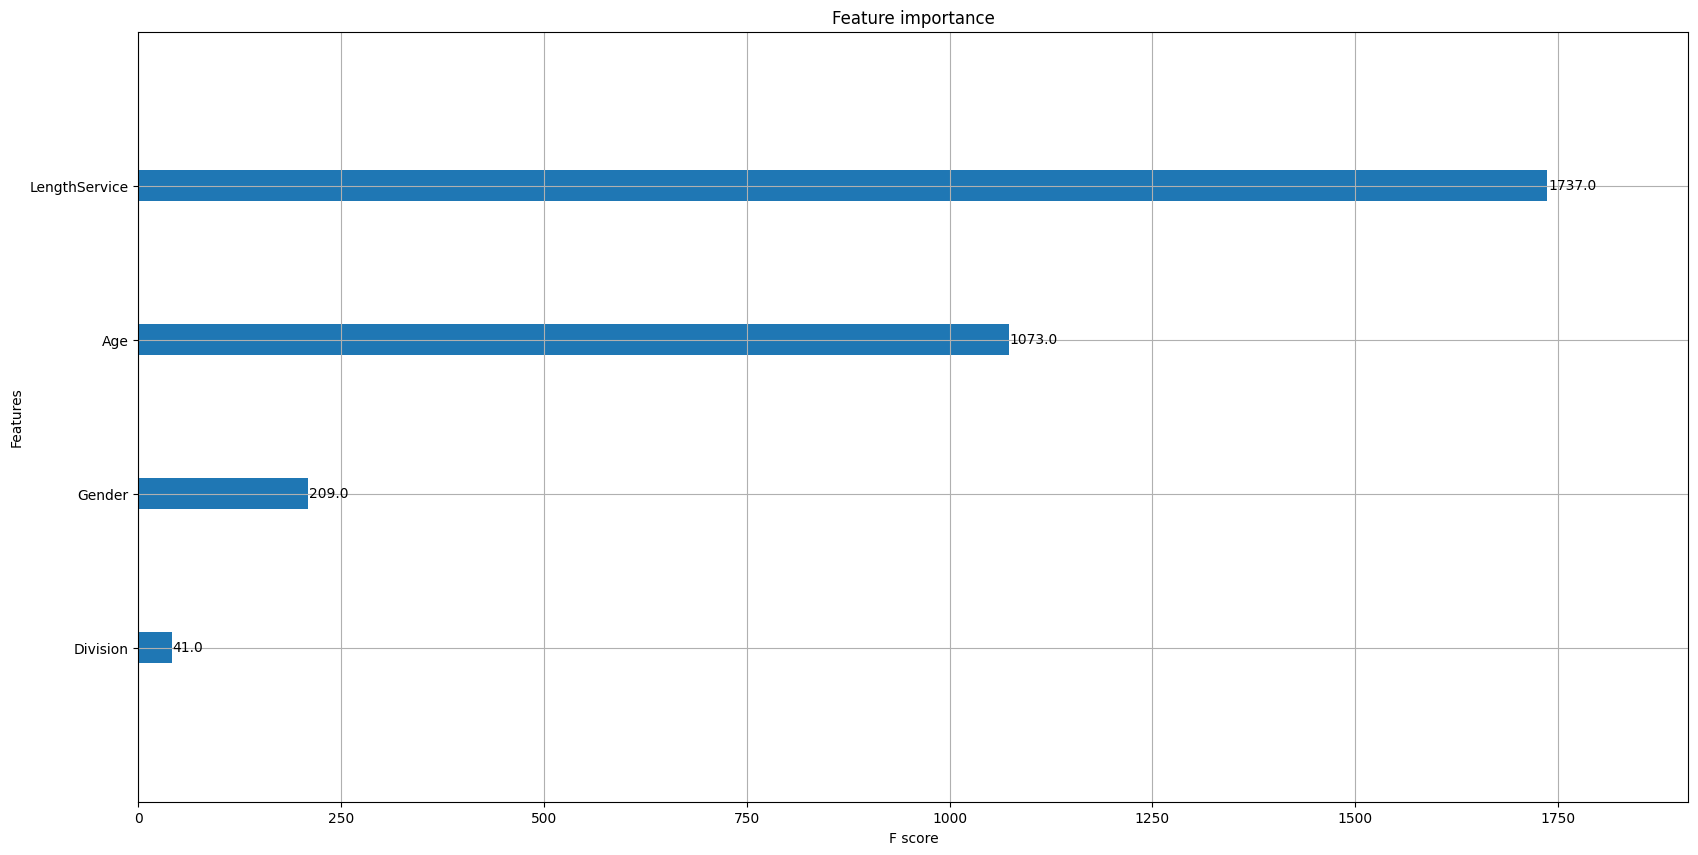

In [974]:
# Now, using the XGBoost Regressor model, we will create a plot to check the feature importance using F score
# The higher the F score, the more important the feature is
plt.figure(figsize=(20, 10))
xgb.plot_importance(model, ax=plt.gca())
plt.show()

### In line with out previous analysis, Absenteeism in employees is mostly correlated with length of service as the most relevant factor, and Age as the second most important factor.
### While gender does have some effect, it is negligible and can be ignored.
### Previously division seemed like a point of interest, but as shown by the model above it has barely any effect at all. This leads us to conclude that the division itself has no impact, it merely reflects the general working environment and type of employees found in each division.

### Going forward managers should consider improving the work environment in their divisions and aim to increase customer loyalty. Providing incentives, whether financial or other, for employees who stick with the company for a long time or find methods to ensure that work environment reaches a satisfactory level for those who work there will do leaps and bounds in decreasing absence. 
## Special attention should be given to employees working in the stores as they show the highest levels of absence.